# MNIST
In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of Machine Learning

In [1]:
#Fetches MNIST Dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function:

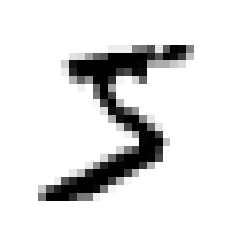

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
#This looks like a 5, and indeed that’s what the label tells us:
y[0]

'5'

In [5]:
# Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:
import numpy as np
y = y.astype(np.uint8)

In [6]:
# But wait! You should always create a test set and set it aside before inspecting the data closely.
# MNIST dataset is actually already split into a training set
#(the first 60,000 images) and a test set (the last 10,000 images):
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). 

 Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. **Shuffling the dataset** ensures that this won’t happen

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [7]:
#This is a cool way of doing this
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class.

This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later.

Let’s create an SGDClassifier and train it on the whole training set:

The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
 sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

## Measuring Accuracy Using Cross-Validation

Let’s use the cross_val_score() function to evaluate our SGDClassifier model, using **K-fold cross-validation** with three folds. Remember that K-fold cross-validation **means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds** 

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 93% accuracy looks amazingn before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s. So if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others)

- Def **Skewed datasets**: when some classes are much more frequent than others.

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix.

The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets.

You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project. Instead, you can use the cross_val_predict() function.

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

With this done we can get the confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

The first row of this matrix considers non-5 images (the negative class): 53,057(53892 in our case) of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,522(687 in our case) were wrongly classified as 5s (false positives). 

The second row considers the images of 5s (the positive class): 1,325(1891 in our case) were wrongly classified as non-5s (false negatives), while the remaining 4,09(3530 in our case)6 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [15]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

# Precision and Recall

- Def **Precision of the classifier**: Look at is the accuracy of the positive predictions. Has the equation 

$$ \text{precision} = \frac{TP}{TP+FP}$$

TP is the number of true positives, and FP is the number of false positives.


Precision is typically used along with another metrics named recall, also called sensitivity or the true positive rate.


- Def **Recall**( sensitivity or the true positive rate (TPR)): This is the ratio of positive instances that are correctly detected by the classifier

$$ \text{recal} = \frac{TP}{TP+FN}$$

FN is, of course, the number of false negatives.

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)  # == 4096 / (4096 + 1325)

0.6511713705958311

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 72.9%(83.7% in our case) of the time. Moreover, it only detects 75.6%(65.1%) of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers.

Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

- Def **F1 Score**:  F1 score is the harmonic mean of precision and recall. 

$$
F_{1}=\frac{2}{\frac{1}{\text { precision }}+\frac{1}{\text { recall }}}=2 \times \frac{\text { precision } \times \text { recall }}{\text { precision }+\text { recall }}=\frac{T P}{T P+\frac{F N+F P}{2}}
$$

In [18]:
# To compute the F1 score: 
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. 

This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision) rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection).

On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the **precision/recall** trade-off.

## Precision/Recall Trade-off

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases recall and reduces precision.

![PrecisionAndRecall](PrecisionAndRecall.PNG)

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. 

Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#The SGDClassifier uses a threshold equal to 0, 
#so the previous code returns the same result as the predict() method (i.e., True)

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [23]:
# With these scores, use the precision_recall_curve() function 
# to compute precision and recall for all possible thresholds:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

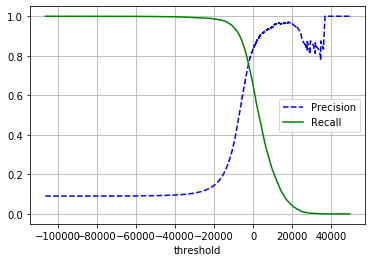

In [24]:
#Finally, use Matplotlib to plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.grid()
    plt.xlabel("threshold")
    #How to add the red dotted line?
    # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
#You may wonder why the precision curve is bumpier than the recall curve in Figure 3-4. 
#The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up).

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 8,000. To be more precise you can search for the lowest threshold that gives you at least 90% precision

(np.argmax() will give you the first index of the maximum value, which in this case means the first True value)

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [26]:
#To make predictions (on the training set for now), instead of calling the classifier’s predict() method, 
#you can run this code:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast. A high-precision classifier is not very useful if its recall is too low!

**TIP**: If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

## The ROC Curve

The **receiver operating characteristic (ROC)** curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the **false positive rate (FPR)**. 

The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:


In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

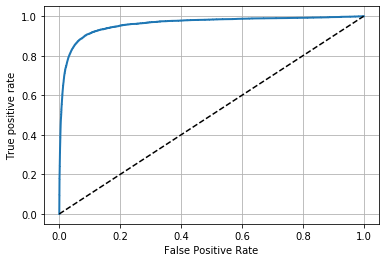

In [30]:
# Then you can plot the FPR against the TPR using Matplotlib.
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True positive rate")
 # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()

## Area under the curve
One way to compare classifiers is to measure the **area under the curve (AUC)**. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**TIP** : Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).


Let’s now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier.

First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), the RandomForestClassifier class does not have a decision_function() method. Instead, it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other, or both. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [33]:
#The roc_curve() function expects labels and scores, 
#but instead of scores you can give it class probabilities. Let’s use the positive class’s probability as the score:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

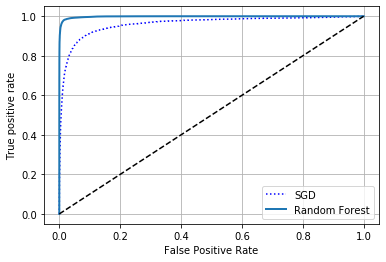

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Try measuring the precision and recall scores: you should find 99.0% precision and 86.6% recall. Not too bad!

 Now let’s try to detect more than just the 5s.

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, **multiclass classifiers (also called multinomial classifiers)** can distinguish between more than two classes.

Some algorithms (such as Logistic Regression classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. 

Others (such as SGD Classifiers or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the **one-versus-the-rest (OvR)** strategy (also called one-versus-all).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the **one-versus-one (OvO) strategy**. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier 

In [36]:
#Don;t run this block just look in the book. This take too long to run on my rig. 
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

NameError: name 'SVC' is not defined

This code trains the SVC on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

If you call the decision_function() method, you will see that it returns 10 scores per instance (instead of just 1). That’s one score per class (it’s the number of won duels plus or minus a small tweak to break ties, based on the binary classifier scores):

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
# Training an SGDClassifier is just as easy:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The decision_function() method now returns one value per class. Let’s look at the score that the SGD classifier assigned to each class:

sgd_clf.decision_function([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

You can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5 has a score of 2412.5. The model has a slight doubt regarding class 3, which gets a score of 573.5. Now of course you want to evaluate this classifier. As usual, you can use cross-validation. Use the cross_val_score() function to evaluate the SGDClassifier’s accuracy:

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89%:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Error Analysis

If this were a real project, you would now follow the steps in your Machine Learning project checklist.

You’d explore data preparation options, try out multiple models and automate as much as possible.

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function, just like you did earlier:

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx
#That’s a lot of numbers.

In [ ]:
#It’s often more convenient to look at an image representation of the confusion matrix,
# using Matplotlib’s matshow() function:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case. 

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#Fill the diagonal with zeros to only keep errors 
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

You can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions).

Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of 3s and 5s (the plot_digits() function just uses Matplotlib’s imshow() function; see this chapter’s Jupyter notebook for details):

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 in the first row and second column truly looks like a badly written 3). However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did.

The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.

# Multilabel Classification

In some cases you may want your classifier to output multiple classes for each instance. Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is called a **multilabel classification system**.

In [1]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

NameError: name 'y_train' is not defined

In [ ]:
#  Now you can make a prediction, and notice that it outputs two labels:
knn_clf.predict([some_digit])
# And it gets it right! The digit 5 is indeed not large (False) and odd (True).

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F1 score across all labels:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

This assumes that all labels are equally important, however, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code.4

# Multioutput Classification

- Def : **multioutput–multiclass classification( or  multioutput classification)** is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

**Tip**: The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels.

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy’s randint() function. The target images will be the original images:

In [2]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

NameError: name 'np' is not defined

In [ ]:
# Now let’s train the classifier and make it clean this image:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)